In [ ]:
from datasets import load_dataset

# Load IMDb dataset
dataset = load_dataset("imdb")

# Optional: use a smaller subset for faster experimentation
dataset["train"] = dataset["train"].shuffle(seed=42).select(range(2000))
dataset["test"] = dataset["test"].shuffle(seed=42).select(range(1000))

# Print a sample review
print(dataset["train"][0])


{'text': 'There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...', 'label': 1}


In [ ]:
from transformers import AutoTokenizer

# Load DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Function to tokenize examples
def preprocess(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

# Apply tokenizer to the dataset
tokenized_dataset = dataset.map(preprocess, batched=True)

# Check a tokenized example
print(tokenized_dataset["train"][0])


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'text': 'There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...', 'label': 1, 'input_ids': [101, 2045, 2003, 2053, 7189, 2012, 2035, 2090, 3481, 3771, 1998, 6337, 2099, 2021, 1996, 2755, 2008, 2119, 2024, 2610, 2186, 2055, 6355, 6997, 1012, 6337, 2099, 3504, 15594, 2100, 1010, 3481, 3771, 350

In [ ]:
from transformers import AutoModelForSequenceClassification

# Load DistilBERT with a classification head for 2 labels (positive/negative)
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,  # positive/negative
)

for param in model.base_model.parameters():
    param.requires_grad = False

# Check the classifier layer
print(model.classifier)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=2, bias=True)


In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
import numpy as np

# Compute accuracy
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

# Data collator handles padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_strategy="no",  # disable logging
    report_to=[],           # disables wandb and other trackers
    fp16=False,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()
results = trainer.evaluate()
print("Test Accuracy:", results["eval_accuracy"])

/tmp/ipython-input-2535651172.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.602187,0.743000
2,No log,0.530504,0.816000
3,No log,0.501930,0.794000
4,No log,0.469981,0.823000
5,No log,0.462787,0.821000


Test Accuracy: 0.821


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

4.57.1


In [ ]:
results = trainer.evaluate()
print("Test Accuracy:", results["eval_accuracy"])

Test Accuracy: 0.821


In [ ]:
import torch

# Make sure model is in evaluation mode
model.eval()

# Function to predict sentiment of a single sentence
def predict_sentiment(sentence):
    # Tokenize the input
    inputs = tokenizer(
        sentence,
        truncation=True,
        padding=True,
        return_tensors="pt"
    )

    # Move inputs to the same device as the model
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward pass (no gradient calculation)
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted class
    logits = outputs.logits
    predicted_class_id = logits.argmax(dim=1).item()
    predicted_label = model.config.id2label[predicted_class_id]

    return predicted_label

# Test examples
examples = [
    "I absolutely loved this movie! It was fantastic.",
    "The film was boring and too long. I did not enjoy it.",
    "An average movie, some good moments but mostly dull."
]

# Run predictions
for sentence in examples:
    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {predict_sentiment(sentence)}\n")


Sentence: I absolutely loved this movie! It was fantastic.
Predicted Sentiment: LABEL_1

Sentence: The film was boring and too long. I did not enjoy it.
Predicted Sentiment: LABEL_0

Sentence: An average movie, some good moments but mostly dull.
Predicted Sentiment: LABEL_0



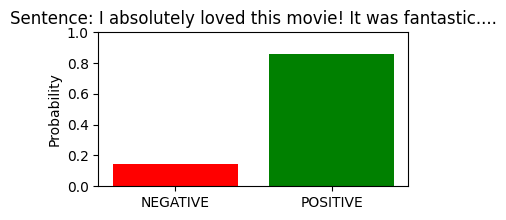

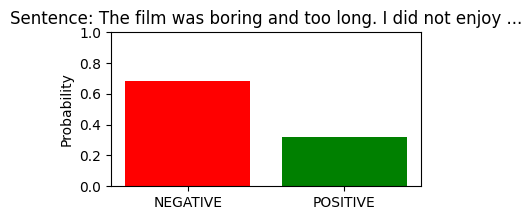

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def visualize_sentiment(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1).cpu().numpy()[0]

    # Plot
    plt.figure(figsize=(4,2))
    plt.bar(["NEGATIVE", "POSITIVE"], probs, color=["red","green"])
    plt.ylim(0,1)
    plt.title(f"Sentence: {sentence[:50]}...")
    plt.ylabel("Probability")
    plt.show()

# Example usage
examples = [
    "I absolutely loved this movie! It was fantastic.",
    "The film was boring and too long. I did not enjoy it."
]

for sentence in examples:
    visualize_sentiment(sentence)
